In [ ]:
# !pip install lightgbm

In [ ]:
#1: Imports

# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from math import radians, cos, sin, asin, sqrt, atan2

# ML
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 2: Load Dataset
df = pd.read_csv("E:\INTTRVU_HACKATHON\dataset.csv")
print("Shape:", df.shape)
display(df.head())
df.info()

Shape: (45593, 11)


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Delivery Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Delivery Time_taken(min)     45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB


In [ ]:
# Column standardization
df.columns = (
    df.columns.str.strip().str.lower().str.replace(" ", "_")
)

df.rename(columns={"delivery_time_taken(min)": "delivery_time"}, inplace=True)

# Drop id
df.drop(columns=['id'], inplace=True, errors='ignore')

# Extract city
df['city'] = df['delivery_person_id'].str.extract(r'([A-Z]+)')
df.drop(columns=['delivery_person_id'], inplace=True)

# Clean categoricals
df['type_of_order'] = df['type_of_order'].str.strip().str.lower()
df['type_of_vehicle'] = df['type_of_vehicle'].str.strip().str.lower()

# Ratings clamp
df['delivery_person_ratings'] = df['delivery_person_ratings'].clip(1,5)

# Handle geo zeros
geo_cols = [
    'restaurant_latitude','restaurant_longitude',
    'delivery_location_latitude','delivery_location_longitude'
]
df = df[~(df[geo_cols] == 0).any(axis=1)]

# Missing handling
num_cols = ['delivery_person_age','delivery_person_ratings']
cat_cols = ['type_of_order','type_of_vehicle','city']

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Datatypes
df['delivery_person_age'] = df['delivery_person_age'].astype(int)
df['delivery_person_ratings'] = df['delivery_person_ratings'].astype(float)

# Sanity filters
df = df[(df['delivery_person_age'] >= 18) & (df['delivery_person_age'] <= 65)]
df = df[df['delivery_time'] > 0]

# Remove duplicates
df.drop_duplicates(inplace=True)

# Outlier capping
Q1 = df['delivery_time'].quantile(0.25)
Q3 = df['delivery_time'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df['delivery_time'] = np.clip(df['delivery_time'], lower, upper)


# Important
lat_mask = (
    np.sign(df['restaurant_latitude']) != np.sign(df['delivery_location_latitude'])
)
lon_mask = (
    np.sign(df['restaurant_longitude']) != np.sign(df['delivery_location_longitude'])
)

df.loc[lat_mask, 'restaurant_latitude'] = abs(df.loc[lat_mask, 'restaurant_latitude'])
df.loc[lon_mask, 'restaurant_longitude'] = abs(df.loc[lon_mask, 'restaurant_longitude'])


In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df['distance_km'] = df.apply(lambda x: haversine(
    x['restaurant_latitude'], x['restaurant_longitude'],
    x['delivery_location_latitude'], x['delivery_location_longitude']
), axis=1)

# FEATURE ENGINNERING

# 1) Partner efficiency (experience proxy)
df['partner_efficiency'] = (
    df['delivery_person_ratings'] * 2 +
    (df['delivery_person_age'] / df['delivery_person_age'].max())
)

# 2) Vehicle speed prior knowledge
vehicle_speed = {
    'motorcycle': 40,
    'scooter': 35,
    'electric_scooter': 30,
    'bicycle': 15
}
df['vehicle_speed'] = df['type_of_vehicle'].map(vehicle_speed)

# 3) Order complexity
order_complexity = {
    'snack': 1,
    'drinks': 1,
    'meal': 2,
    'buffet': 3
}
df['order_complexity'] = df['type_of_order'].map(order_complexity)

# 5) Age group segmentation
df['age_group'] = pd.cut(
    df['delivery_person_age'],
    bins=[18,25,35,50,65],
    labels=['young','adult','mid_age','senior']
)


In [ ]:
# ---------- CLEANING & SANITY CHECK FOR ENGINEERED FEATURES ----------

# 1) Distance sanity (remove unrealistic logistics values)
df = df[(df['distance_km'] > 0.5) & (df['distance_km'] < 40)]

# 2) Vehicle speed mapping missing handling
df['vehicle_speed'].fillna(df['vehicle_speed'].median(), inplace=True)

# 3) Order complexity missing handling
df['order_complexity'].fillna(df['order_complexity'].median(), inplace=True)

# 4) Partner efficiency normalization (balanced scale)
df['partner_efficiency'] = (
    (df['delivery_person_ratings'] / 5) * 0.7 +
    (df['delivery_person_age'] / 65) * 0.3
)

# 5) Delivery speed proxy cleanup
df['speed_km_per_min'] = df['distance_km'] / df['delivery_time']
df['speed_km_per_min'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['speed_km_per_min'].fillna(df['speed_km_per_min'].median(), inplace=True)

# 6) Age group categorical safety
df['age_group'] = df['age_group'].astype(str)
df['age_group'].replace('nan', 'adult', inplace=True)

# 7) Final duplicate check after feature creation
df.drop_duplicates(inplace=True)

# 8) Final null audit
print(df.isnull().sum())
print("Shape after feature cleaning:", df.shape)


delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
type_of_order                  0
type_of_vehicle                0
delivery_time                  0
city                           0
distance_km                    0
partner_efficiency             0
vehicle_speed                  0
order_complexity               0
age_group                      0
speed_km_per_min               0
dtype: int64
Shape after feature cleaning: (41906, 16)


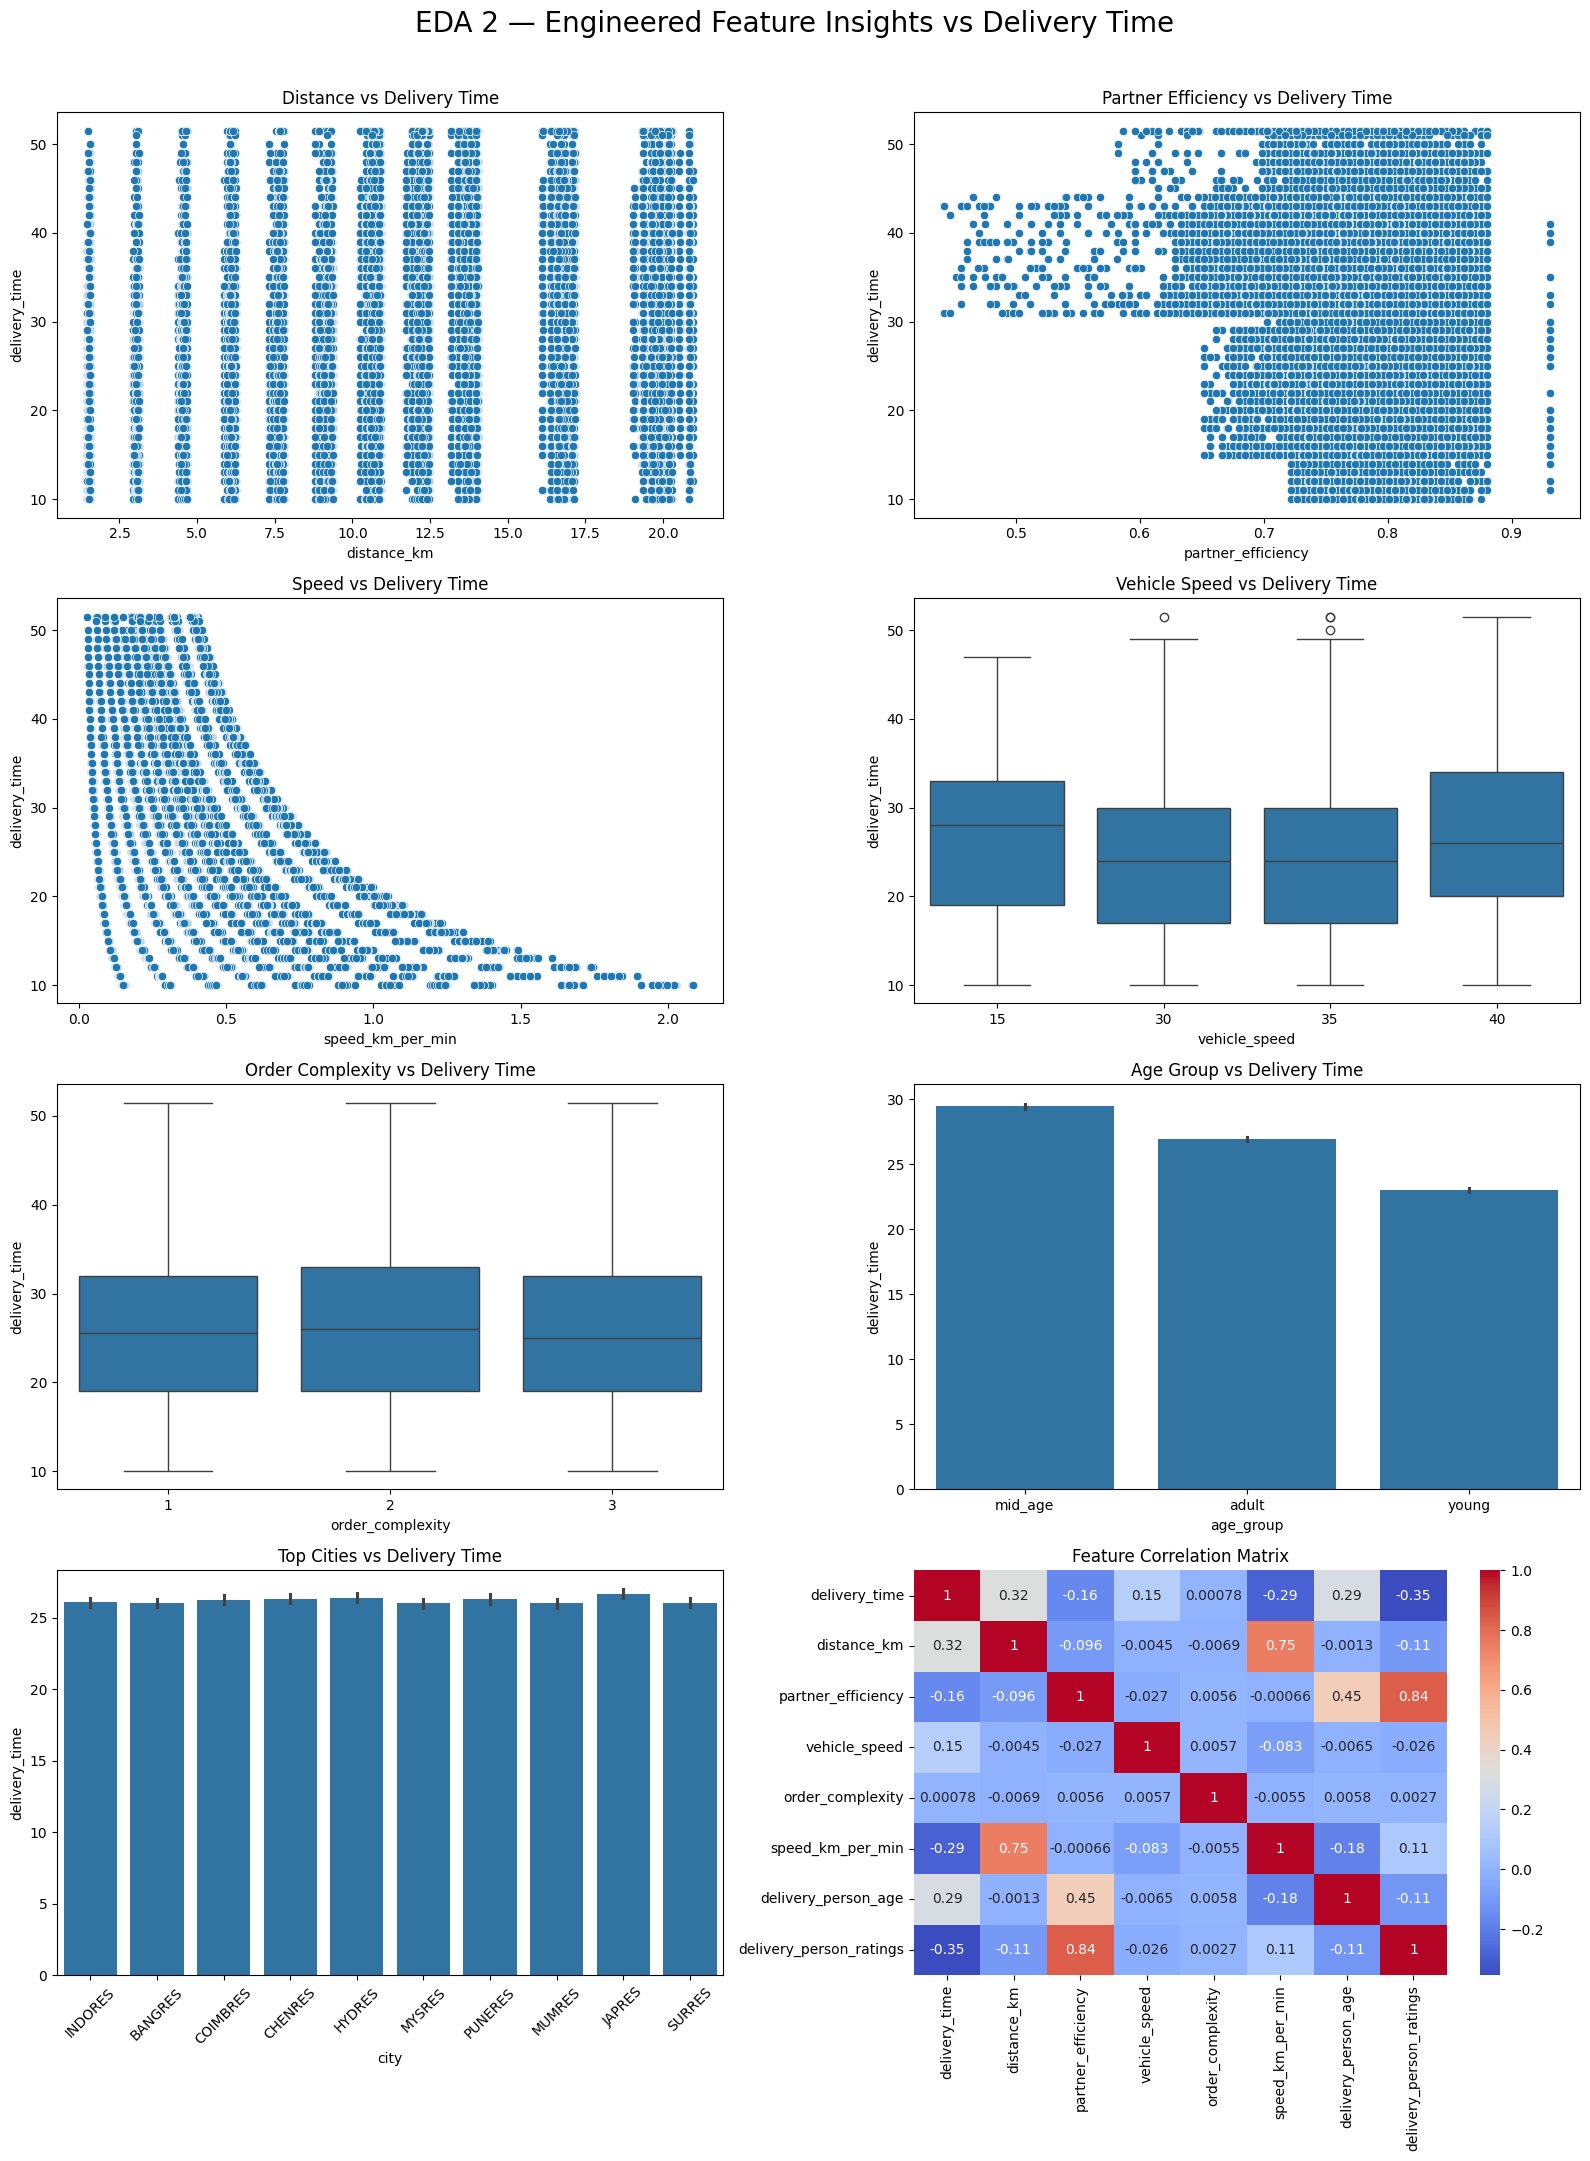

In [ ]:
# ---------- EDA 2 : FEATURE ENGINEERING IMPACT (MODEL-DRIVEN INSIGHTS) ----------

fig, axes = plt.subplots(4, 2, figsize=(16, 22))
fig.suptitle("EDA 2 — Engineered Feature Insights vs Delivery Time", fontsize=20)

# 1️⃣ Distance vs Delivery Time
sns.scatterplot(x='distance_km', y='delivery_time', data=df, ax=axes[0,0])
axes[0,0].set_title("Distance vs Delivery Time")

# 2️⃣ Partner Efficiency vs Delivery Time
sns.scatterplot(x='partner_efficiency', y='delivery_time', data=df, ax=axes[0,1])
axes[0,1].set_title("Partner Efficiency vs Delivery Time")

# 3️⃣ Speed Proxy vs Delivery Time
sns.scatterplot(x='speed_km_per_min', y='delivery_time', data=df, ax=axes[1,0])
axes[1,0].set_title("Speed vs Delivery Time")

# 4️⃣ Vehicle Speed Impact
sns.boxplot(x='vehicle_speed', y='delivery_time', data=df, ax=axes[1,1])
axes[1,1].set_title("Vehicle Speed vs Delivery Time")

# 5️⃣ Order Complexity Impact
sns.boxplot(x='order_complexity', y='delivery_time', data=df, ax=axes[2,0])
axes[2,0].set_title("Order Complexity vs Delivery Time")

# 6️⃣ Age Group Impact
sns.barplot(x='age_group', y='delivery_time', data=df, ax=axes[2,1])
axes[2,1].set_title("Age Group vs Delivery Time")

# 7️⃣ City Performance
top_cities = df['city'].value_counts().nlargest(10).index
sns.barplot(x='city', y='delivery_time', data=df[df['city'].isin(top_cities)], ax=axes[3,0])
axes[3,0].set_title("Top Cities vs Delivery Time")
axes[3,0].tick_params(axis='x', rotation=45)

# 8️⃣ Feature Correlation (Engineered + Core)
important_cols = [
    'delivery_time','distance_km','partner_efficiency',
    'vehicle_speed','order_complexity','speed_km_per_min',
    'delivery_person_age','delivery_person_ratings'
]
sns.heatmap(df[important_cols].corr(), annot=True, cmap='coolwarm', ax=axes[3,1])
axes[3,1].set_title("Feature Correlation Matrix")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
# Target
y = df['delivery_time']

X = df.drop(columns='delivery_time')

categorical_cols = ['type_of_vehicle','type_of_order','city','age_group']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, X_test.shape)

(33524, 40) (8382, 40)


In [ ]:
# Step 4 — Baseline model (must for hackathon)
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)


In [ ]:
# Step 5 — Evaluation metrics
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} RMSE:", rmse)
    print(f"{model_name} MAE:", mae)
    
evaluate(y_test, lr_pred, "Linear Regression")

Linear Regression RMSE: 4.593129516646122
Linear Regression MAE: 3.4093478223460285


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("LR RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("LR MAE:", mean_absolute_error(y_test, pred_lr))


LR RMSE: 8.361800609989196
LR MAE: 6.609057730168908


In [ ]:

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

evaluate(y_test, rf_pred, "Random Forest")


Random Forest RMSE: 0.3011837899336809
Random Forest MAE: 0.11463673332811415


In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

evaluate(y_test, xgb_pred, "XGBoost")


XGBoost RMSE: 0.4528679691690081
XGBoost MAE: 0.23685649914151016


In [ ]:
    
    
    lgb_model = lgb.LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=10,
        random_state=42
    )
    
    lgb_model.fit(X_train, y_train)
    
    lgb_pred = lgb_model.predict(X_test)
    
    evaluate(y_test, lgb_pred, "LightGBM")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 33524, number of used features: 40
[LightGBM] [Info] Start training from score 26.326318
LightGBM RMSE: 0.4920116409190097
LightGBM MAE: 0.29136266250456844


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Assuming lr_pred, rf_pred, xgb_pred, lgb_pred are your model predictions
results = pd.DataFrame({
    "Model": ["Linear(Base Model)", "RandomForest", "XGBoost", "LightGBM"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(y_test, xgb_pred)),
        np.sqrt(mean_squared_error(y_test, lgb_pred))
    ],
    "MAE": [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, xgb_pred),
        mean_absolute_error(y_test, lgb_pred)
    ],
    "R²": [
        r2_score(y_test, lr_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, xgb_pred),
        r2_score(y_test, lgb_pred)
    ]
})

# Sort by RMSE
results_sorted = results.sort_values(by="RMSE")
print(results_sorted)
`

                Model      RMSE       MAE        R²
1        RandomForest  0.301184  0.114637  0.998960
2             XGBoost  0.452868  0.236856  0.997648
3            LightGBM  0.492012  0.291363  0.997224
0  Linear(Base Model)  4.593130  3.409348  0.758057
